In [ ]:
#import libraries needed
import numpy as np
import scipy.sparse.linalg
import pandas as pd
import matplotlib.pyplot as plt

import math

In [ ]:
#Load data into memory
data = pd.read_csv('./data.csv')

print(data.head())
print(data.shape)

# We can skip data cleaning because dataset is already processed

In [ ]:
#Convert data into a matrix
data = np.array(data)   #we will lose the name of the columns and the row number
print(data.shape)

X0 = data[:, 1:].T
print(X0.shape)

Y0 = data[:, 0]
print(Y0.shape)

In [ ]:
#Visualize the image of index 'idx' from the dataset 'X'
def visualize(X, idx):
    #Load an image in memory
    img = X[:,idx] 

    #Reshaspe --> opposite of flattening: from vector to matrix
    img = np.reshape(img, (28, 28)) 

    #Visualize
    plt.imshow(img, cmap='gray')     #cmap: how to convert pixel in colors
    plt.show()

#Visualize image number 9 and the corresponding digit
idx = [index for index, elem in enumerate(Y0) if elem == 9]
visualize(X0, idx[0])
print(f"The associated digit is: {Y0[idx[0]]}") #the correspondence

In [ ]:
def choose_labels(labels):
    idx = [index for index, elem in enumerate(Y0) if elem in labels]

    X = X0[:, idx]     #take all the rows and just the columns idx
    Y = Y0[idx]

    return X, Y

In [ ]:
classes = [0, 6, 9]
X, Y = choose_labels(classes)

print(X.shape, Y.shape)

In [ ]:
def split_data(X, Y, Ntrain):

    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

In [ ]:
Ntrain = 8000

(Xtrain, Ytrain) ,(Xtest, Ytest) = split_data(X,Y,Ntrain)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

In [86]:
def get_centroid(X):
    return np.mean(X, axis=1)   #axis = 1: applied by row

def centroid_of_cluster(Z, Y, label):
    '''
    Z is the reduced dataset
    Y is the labels array
    label is the class of the cluster
    '''
    return get_centroid(Z[:, Y==label])

def get_centroids(Z, Y, labels):
    
    centroids = []
    
    for label in labels:
        centroids.append(centroid_of_cluster(Z, Y, label))

    return centroids

In [87]:
def PCA(X, k):
    centroidX = get_centroid(X)
    r, = centroidX.shape
    centroidX = np.reshape(centroidX, (r, 1))
    X_c = X - centroidX

    U, S, VT = np.linalg.svd(X_c, full_matrices=False) #full_matrices=false -> the shapes are (..., M, K) and (..., K, N), respectively, where K = min(M, N)

    U_k = U[:, :k]
    Z_k = U_k.T @ X_c

    return Z_k, U_k

In [88]:
def LDA(Xtrain, Ytrain, classes, k):
    d, N = Xtrain.shape

    #Find the corresponding indeces
    Xtrain_lda = []
    Ytrain_lda = []
    
    for label in classes:
        index = (Ytrain==label)
        Xtrain_lda += [Xtrain[:, index],]
        Ytrain_lda.append(Ytrain[index])
     
    X = np.concatenate(Xtrain_lda, axis=1)
    Y = np.concatenate(Ytrain_lda)

    # Class centroids
    centroids = []
    for x in Xtrain_lda:
        c = get_centroid(x)
        c = np.reshape(c, (d, 1))
        centroids.append(c)
    
    
    #centroids = [np.reshape(get_centroid(x), (d,1)) for x in Xtrain_lda]

    # Global centroid
    C = get_centroid(X)

    #Within-clusters Scatter Matrix

    X_ci = []
    for i in range(len(Xtrain_lda)):
        X_ci.append(Xtrain_lda[i] - centroids[i])
    #c_i was reshaped to do difference between matrix and column vector 
    

    X_w = np.concatenate(X_ci, axis=1)

    S_w = X_w @ X_w.T

    # Between-clusters Scatter Matrix
    Xi_bar = []
    for i in range(len(Xtrain_lda)):
        Xi_bar.append(np.repeat(centroids[i], Xtrain_lda[i].shape[1], axis=1))

    X_bar = np.concatenate(Xi_bar, axis=1)
   
    Xc_bar = X_bar - C.reshape(d,1)
    S_b = Xc_bar @ Xc_bar.T

    #We want to compute the Cholesky decomposition
    try:
        L = np.linalg.cholesky(S_w)
    except:
        eps = 1e-6
        S_w = S_w + eps * np.eye(S_w.shape[0])
        
        L = np.linalg.cholesky(S_w)

    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ S_b @ L, k=k) #the two largest eigenvalues andd the corresponding eigenvector
    W = np.real(W)
    
    Q = np.linalg.inv(L).T @ W

    Z = Q.T @ X

    return Z, Q


In [100]:
def plot(Z, Y, classes, k, colors, legend):

    clusters = []
    centroids = []
    i = 0

    if(k==3):
        ax = plt.axes(projection="3d")
    
    for label in classes:
        if(k==2):
            fig = plt.scatter(Z[0,Y==label],Z[1,Y==label],marker="o", color=colors[i])
        elif(k==3):
            fig = ax.scatter3D(Z[0,Y==label],Z[1,Y==label],Z[2, Y==label],marker="o", color=colors[i])
        clusters.append(fig)
        i+=1

    plt.legend(legend)

    for label in classes:
        centr = get_centroid(Z[:, Y==label])
        if(k==2):
            plt.scatter(centr[0], centr[1], marker='*', color='red')
        elif(k==3):
            ax.scatter3D(centr[0], centr[1], centr[2], marker='*', color='red')
        centroids.append(centr)

    
    plt.grid()
    plt.legend(legend)

    plt.show()

    return clusters, centroids

PCA
[909.37136412 -30.91461325]
[-307.6925997  -392.04817349]
[-587.79981663  412.98172224]


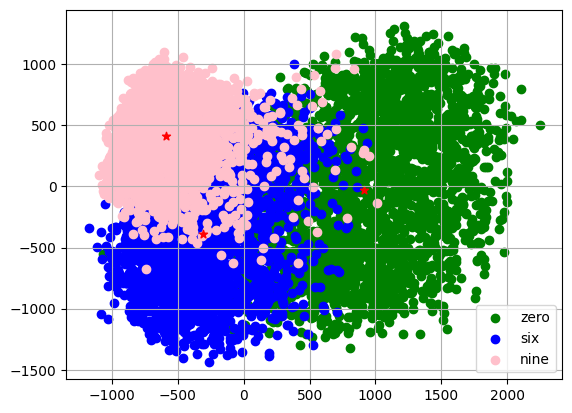

LDA
[-0.04256199  0.0008071 ]
[0.0066458  0.04336303]
[ 0.03925295 -0.03905567]


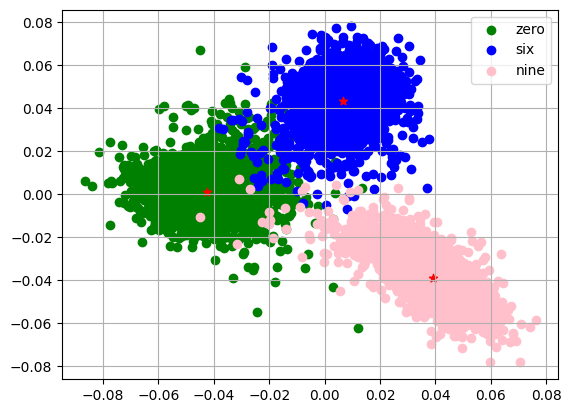

In [102]:
classes = [0, 6, 9]
X, Y = choose_labels(classes)
k=2

(Xtrain, Ytrain) ,(Xtest, Ytest) = split_data(X,Y,Ntrain=8000)

#PCA
print("PCA")
Z_pca, proj_PCA = PCA(Xtrain, k)
colors = ['green', 'blue', 'pink']
legend = ["zero","six","nine"]
cluster_pca, centroid_pca = plot(Z_pca, Ytrain, classes, k, colors, legend)


#LDA
print("LDA")
Z_lda, proj_LDA = LDA(Xtrain, Ytrain, classes, k)
Y1 = Ytrain[Ytrain==0]
Y2 = Ytrain[Ytrain==6]
Y3 = Ytrain[Ytrain==9]
Y_lda = np.concatenate((Y1,Y2,Y3))
cluster_lda, centroid_lda = plot(Z_lda, Y_lda, classes, k, colors, legend)

In [92]:
def distance_from_centroid(clusters, centroids):
    centroid_index = 0
    distances = []

    for cl in clusters:
        points = cl.get_offsets().data
        r, c = points.shape

        dist_point_centr = []

        for i in range(r):
            d = np.linalg.norm(points[i] - centroids[centroid_index], 2)
            dist_point_centr.append(d)

        average = sum(dist_point_centr)/r
        distances.append(average)

        centroid_index += 1
    
    return distances

In [ ]:
distances_pca = distance_from_centroid(cluster_pca, centroid_pca)
print(f"PCA distances: 0 --> {distances_pca[0]}, \t 6--> {distances_pca[1]}, \t 9--> {distances_pca[2]}")

distances_lda = distance_from_centroid(cluster_lda, centroid_lda)
print(f"LDA distances: 0 --> {distances_lda[0]}, \t 6--> {distances_lda[1]}, \t 9--> {distances_lda[2]}")

In [ ]:
centroidX_test = get_centroid(Xtest)
Z_pca_test =  proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))
clusters_pca, centroids_pca = plot(Z_pca_test, Ytest)

Z_lda_test = proj_LDA.T @ Xtest
clusters_lda, centroids_lda = plot(Z_lda_test, Ytest)

distances_pca_test = distance_from_centroid(clusters_pca, centroids_pca)
print(f"PCA distances: 0 --> {distances_pca_test[0]}, \t 6--> {distances_pca_test[1]}, \t 9--> {distances_pca_test[2]}")

distances_lda_test = distance_from_centroid(clusters_lda, centroids_lda)
print(f"LDA distances: 0 --> {distances_lda_test[0]}, \t 6--> {distances_lda_test[1]}, \t 9--> {distances_lda_test[2]}")

In [93]:
def classification_algorithm(obs, centroids, gt):
    distance_obs_clusters = []

    for i in range (len(centroids)):
        d = np.linalg.norm(obs - centroids[i], 2)
        distance_obs_clusters.append(d)

    min_index = np.argmin(distance_obs_clusters)

    predicted_class = classes[min_index]

    return predicted_class == gt

def accuracy(X, centroids, Y):
    results = [classification_algorithm(X[:, i], centroids, gt) for i, gt in enumerate(Y)]

    correct_pred = np.sum(results)

    correctness = correct_pred / len(Y)
    print(f'Percentage of correct classifications: {correctness}')
    
    return correctness

In [94]:
classes = [0, 6, 9]

Z_pca_train, proj_PCA = PCA(Xtrain, 2)
centroidX_test = get_centroid(Xtest)
Z_pca_test =  proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))
centroids_pca = get_centroids(Z_pca_train, Ytrain, classes)

Y_lda_mat = []
for label in classes:
    Y_lda_mat.append(Ytrain[Ytrain==label])

Y_lda = np.concatenate(Y_lda_mat)

Z_lda_train, proj_LDA = LDA(Xtrain, Ytrain, classes, 2)
Z_lda_test = proj_LDA.T @ Xtest
centroids_lda = get_centroids(Z_lda_train, Y_lda, classes)

print('PCA')
accuracy_pca = accuracy(Z_pca_train, centroids_pca, Ytrain)
accuracy_pca = accuracy(Z_pca_test, centroids_pca, Ytest)

print('LDA')
accuracy_lda = accuracy(Z_lda_train, centroids_lda, Y_lda) 
accuracy_lda = accuracy(Z_lda_test, centroids_lda, Ytest) 

PCA
Percentage of correct classifications: 0.84025
Percentage of correct classifications: 0.8415974870989454
LDA
Percentage of correct classifications: 0.989875
Percentage of correct classifications: 0.977563383441777


In [95]:
def try_PCA_LDA(Xtrain, Ytrain, Xtest, Ytest, classes, k):

    print(f"k={k}")

    Zpca_train, new_proj_PCA = PCA(Xtrain, k)
    Zlda_train, new_proj_LDA = LDA(Xtrain, Ytrain, classes, k)

    centroidX_test = get_centroid(Xtest)
    Z_test_pca_new = new_proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))

    Z_test_lda_new = new_proj_LDA.T @ Xtest

    Y_lda_mat = []
    for label in classes:
        Y_lda_mat.append(Ytrain[Ytrain==label])
    Y_lda = np.concatenate(Y_lda_mat)

    centroids_pca_new = get_centroids(Zpca_train, Ytrain, classes)
    centroids_lda_new = get_centroids(Zlda_train, Y_lda, classes)
   
    print('PCA')
    accuracy_pca = accuracy(Z_test_pca_new, centroids_pca_new, Ytest)

    print('LDA')
    accuracy_lda = accuracy(Z_test_lda_new, centroids_lda_new, Ytest)

In [103]:
classes = [0, 5, 7, 9]

X, Y = choose_labels(classes)
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, Ntrain=8000)

k_test = np.array((2, 3, 4))


for k in k_test:
    try_PCA_LDA(Xtrain, Ytrain, Xtest, Ytest, classes, k)

k=2
PCA
Percentage of correct classifications: 0.6396195396899953
LDA
Percentage of correct classifications: 0.906763738844528
k=3
PCA
Percentage of correct classifications: 0.7629168623767026
LDA
Percentage of correct classifications: 0.9484499765147957
k=4
PCA
Percentage of correct classifications: 0.8152888680131517
LDA
Percentage of correct classifications: 0.9473931423203382
